In [1]:
# STEP 1: Authenticate and download dataset from Kaggle
from google.colab import files
uploaded = files.upload()  # Upload kaggle.json

import os, zipfile
json_filename = list(uploaded.keys())[0]
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!mkdir -p ~/.kaggle
!cp {json_filename} ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip -d PlantVillageRaw

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 96% 632M/658M [00:05<00:00, 131MB/s]
100% 658M/658M [00:05<00:00, 124MB/s]


In [4]:
# STEP 2: Organize data into train/val/test folders (fixed for case-sensitive extensions)
import shutil, random
from pathlib import Path

data_dir = Path("PlantVillageRaw/PlantVillage")
output_dirs = {'train': Path("train"), 'val': Path("val"), 'test': Path("test")}
for split in output_dirs.values():
    shutil.rmtree(split, ignore_errors=True)

all_classes = [f.name for f in data_dir.iterdir() if f.is_dir()]
for split in output_dirs:
    for cls in all_classes:
        os.makedirs(output_dirs[split] / cls, exist_ok=True)

def get_all_images(folder):
    return [p for p in folder.iterdir() if p.suffix.lower() in ['.jpg', '.jpeg', '.png']]

for cls in all_classes:
    class_path = data_dir / cls
    images = get_all_images(class_path)
    random.shuffle(images)
    n = len(images)
    t, v = int(0.8 * n), int(0.1 * n)
    splits = {'train': images[:t], 'val': images[t:t+v], 'test': images[t+v:]}
    for split in splits:
        for img in splits[split]:
            shutil.copy(img, output_dirs[split] / cls / img.name)


In [5]:
# STEP 3: DeiT Implementation
!pip install -q transformers timm torchmetrics seaborn

import time
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from transformers import DeiTForImageClassification
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_ds = ImageFolder("train", transform=transform)
val_ds = ImageFolder("val", transform=transform)
test_ds = ImageFolder("test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

# Model
model = DeiTForImageClassification.from_pretrained(
    "facebook/deit-base-distilled-patch16-224",
    num_labels=len(train_ds.classes)
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
epochs = 10

train_accs, val_accs, train_losses, val_losses = [], [], [], []
start_time = time.time()

for epoch in range(epochs):
    model.train()
    correct, total, train_loss = 0, 0, 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        outputs = model(imgs).logits
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == lbls).sum().item()
        total += lbls.size(0)
    train_losses.append(train_loss / total)
    train_accs.append(correct / total)

    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs).logits
            val_loss += criterion(outputs, lbls).item() * imgs.size(0)
            correct += (outputs.argmax(1) == lbls).sum().item()
            total += lbls.size(0)
    val_losses.append(val_loss / total)
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}: Train Acc={train_accs[-1]:.4f}, Val Acc={val_accs[-1]:.4f}")

training_time = time.time() - start_time

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

Epoch 1: Train Acc=0.9492, Val Acc=0.9869
Epoch 2: Train Acc=0.9990, Val Acc=0.9971


KeyboardInterrupt: 

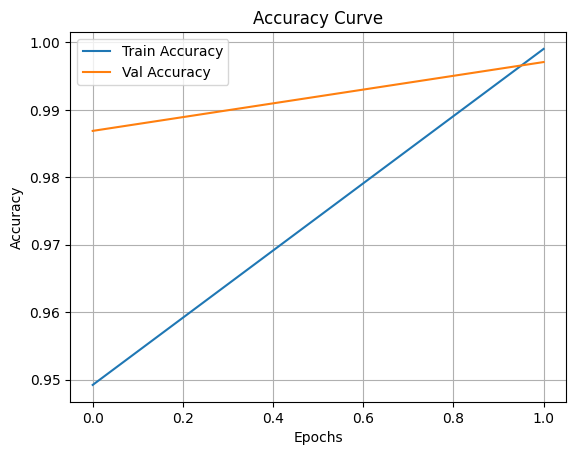


📊 Classification Report:
                                              precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00       101
                     Pepper__bell___healthy       1.00      1.00      1.00       149
                      Potato___Early_blight       1.00      1.00      1.00       100
                       Potato___Late_blight       1.00      1.00      1.00       100
                           Potato___healthy       1.00      1.00      1.00        16
                      Tomato_Bacterial_spot       1.00      1.00      1.00       214
                        Tomato_Early_blight       0.98      0.97      0.97       100
                         Tomato_Late_blight       0.99      0.99      0.99       192
                           Tomato_Leaf_Mold       1.00      1.00      1.00        96
                  Tomato_Septoria_leaf_spot       0.99      0.99      0.99       178
Tomato_Spider_mites_Two_spotted_spide

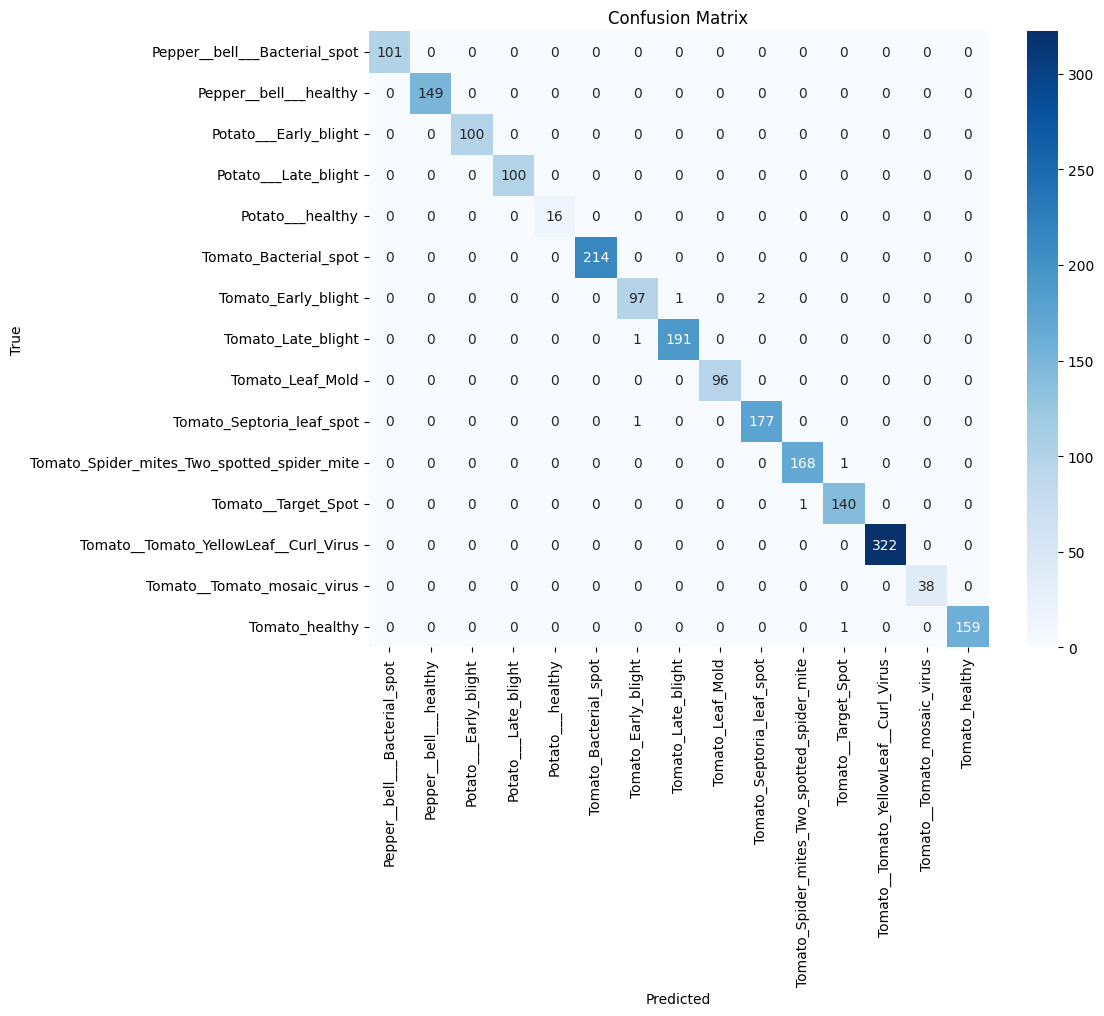

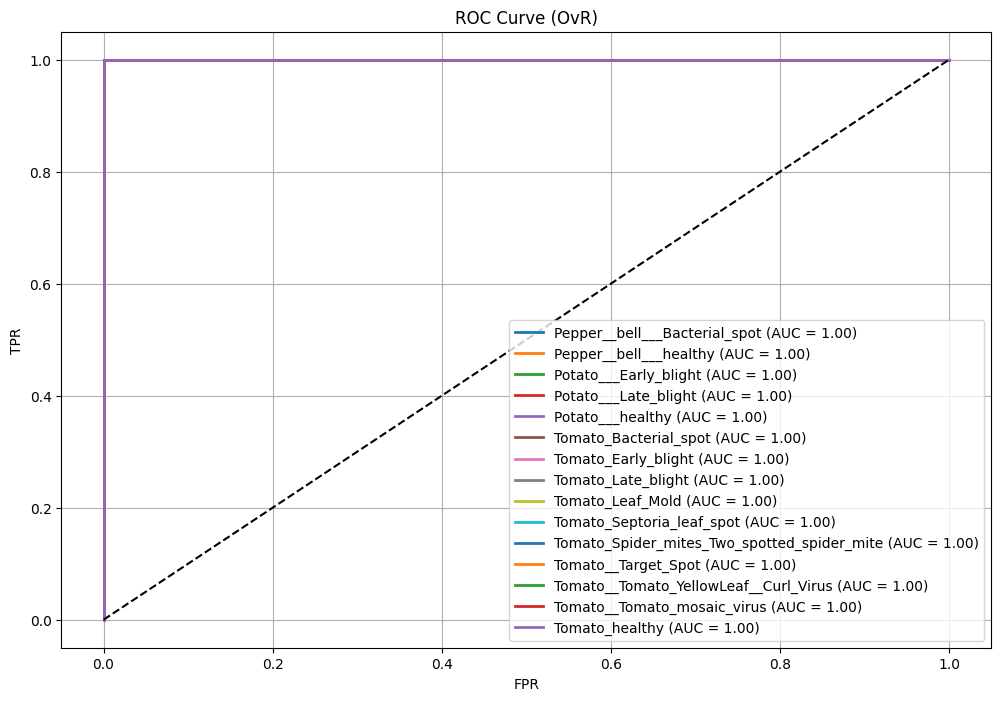

🧮 Macro AUC: 1.0000
🧮 Weighted AUC: 1.0000

✅ Final Train Accuracy: 99.90%
✅ Final Validation Accuracy: 99.71%
✅ Test Accuracy: 99.61%


NameError: name 'training_time' is not defined

In [6]:
# STEP 4: Final Evaluation
model.eval()
y_true, y_pred_probs = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs).logits
        y_pred_probs.append(outputs.cpu())
        y_true.append(lbls)

y_pred_probs = torch.cat(y_pred_probs).softmax(dim=1).numpy()
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = torch.cat(y_true).numpy()
class_labels = train_ds.classes

# Plot Loss and Accuracy
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

# Classification Report
print("\n📊 Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# AUC-ROC
y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))
plt.figure(figsize=(12, 8))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (OvR)")
plt.legend()
plt.grid(True)
plt.show()

# Macro & Weighted AUC
print(f"🧮 Macro AUC: {roc_auc_score(y_true_bin, y_pred_probs, average='macro'):.4f}")
print(f"🧮 Weighted AUC: {roc_auc_score(y_true_bin, y_pred_probs, average='weighted'):.4f}")

# STEP 5: Summary
model_size = sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / (1024 ** 2)
print(f"\n✅ Final Train Accuracy: {train_accs[-1]*100:.2f}%")
print(f"✅ Final Validation Accuracy: {val_accs[-1]*100:.2f}%")
print(f"✅ Test Accuracy: {(y_pred == y_true).mean()*100:.2f}%")
print(f"⏱️ Total Training Time: {training_time:.2f} seconds")
print(f"📦 Model Size: {model_size:.2f} MB")